In [1]:
from qiskit import *
import numpy as np
from IPython.display import clear_output
from scipy.optimize import  minimize
%matplotlib inline
clear_output()


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open')
state_simulator = Aer.get_backend('statevector_simulator')
backend_experimet = Aer.get_backend('qasm_simulator')
# backend = provider.get_backend('ibmq_qasm_simulator')

C:\Users\acer_\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
def kron(*matrices):
    """
    Inputs:
    matrices m1, m2, ...
    
    Returns:
    The Kronecker product m1 x m2 x ...
    """
    m1, m2, *ms = matrices
    m3 = np.kron(m1, m2)
    
    for m in ms:
        m3 = np.kron(m3, m)
    
    return m3


def bloch_vetor(v):
    """
    Inputs:
    A vector state 'v'
    
    Returns:
    The Bloch vector of 'v'
    """
    X, Y, Z = np.array([[0,1], [1,0]]), np.array([[0,-1j], [1j,0]]), np.array([[1,0], [0,-1]])
    rho = np.outer(v, np.conjugate(v))
    r1,r2,r3 = np.trace(rho@X), np.trace(rho@Y), np.trace(rho@Z)
    return np.real(np.array([r1,r2,r3]))


def qubit(theta, phi):
    """
    Inputs:
    theta: Polar angle
    phi: Azimuthal angle
    
    Returns:
    A 2-dimensional vector state of norm 1
    """
    return np.cos(theta/2)*np.array([1,0]) + np.exp(phi*1j)*np.sin(theta/2)*np.array([0,1])


def random_qubit():
    """
    Returns:
    A random qubit state
    """
    theta = np.pi*np.random.random_sample()
    phi = 2*np.pi*np.random.random_sample()
    
    return qubit(theta, phi)


def gates():
    """
    Inputs:
    None
    
    Returns:
    All the necessary gates for the circuits
    """
    
    
    H = np.array([[1,1],
                  [1,-1]])/np.sqrt(2)  # Hadamard Gate


    cc_not = np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                       [0., 1., 0., 0., 0., 0., 0., 0.],
                       [0., 0., 1., 0., 0., 0., 0., 0.],
                       [0., 0., 0., 1., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 1., 0., 0., 0.],
                       [0., 0., 0., 0., 0., 1., 0., 0.],
                       [0., 0., 0., 0., 0., 0., 0., 1.],
                       [0., 0., 0., 0., 0., 0., 1., 0.]])

    c_not_2 = np.array([[1,0,0,0],     #CNOT2 gate
                        [0,0,0,1],
                        [0,0,1,0],
                        [0,1,0,0]])

    SWAP = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.],
                     [0., 1., 0., 0.],
                     [0., 0., 0., 1.]])

    return H, cc_not, c_not_2, SWAP


def storestring(P, register):
    
    if abs(P - 1) <= 1e-8:
        digit = register[-1]
        register += digit
    else:
        digit = bin(int('1',2) + int(register[-1],2))[-1]
        register += digit

    return register


def qubit_string(bit_string):
    """
    Input:
    A bit string in a numpy array
    
    Returns:
    A product state generated from the bit_string
    """
    I = np.identity(2)
    i,j = bit_string[0], bit_string[1]
    product_state = np.kron(I[i], I[j])
    
    for k in bit_string[2:]:
        product_state = np.kron(product_state, I[k])
    
    return product_state



def swap_test_Nq(N, unknown_state):
    """
    We want to determine "bitstring" such that |bitstring> = unknown_state
    
    Inputs:
    N: Number of qubits
    unknown_state: The state whose "bitstring" is to be determined
    
    returns:
    bitstring
    """
    
    N = N + 1
    
    I2, IN, found_string = np.identity(2), np.identity( 2**N ), '0'
    
    initial_qubits = kron( I2[0], I2[0],  unknown_state )
    
    H0, cc_not, c_not_2, SWAP = gates() #load gates
    
    H, Z0 = kron( H0, IN ), np.outer( I2[0], I2[0] )  # H is the Hadamar gate and Z0 = |0><0|
    
    C00 = kron( Z0, IN ) # Needed to compute the Fredkin gate

    found_string = storestring(1, found_string)  # store the bit
    
    
    for n in range(1,N):  
        
        d1, d2 = 2**(n - 1), 2**(N - n - 1)
        
        SWAP11 = kron( np.outer(I2[1],I2[1]), np.identity(d1), SWAP, np.identity(d2) ) # Needed to compute the Fredkin gate
        
        F = C00 + SWAP11  # Fredkin gate

        measured_state = H @ F @ H @ initial_qubits # Circuit

        P = measured_state @ kron( Z0, IN ) @ np.conjugate(measured_state) #compute the probability
        
        found_string = storestring(P, found_string) # store the bit

        
    return ''.join(found_string[2:])


def parameters():
    """ 
    Returns:
    Random parameters to generate qubit vector states
    """
    theta = np.pi*np.random.random_sample()
    phi = 2*np.pi*np.random.random_sample()
    
    return theta, phi

### 1. Generating a random state

This can be achieved in qiskit by applying the $U_{3}(\theta, \phi, \lambda)$ gate to $| 0 \rangle$. 

$U_{3}(\theta, \phi, \lambda) | 0 \rangle = cos(\theta/2)| 0 \rangle + e^{i\phi}sin(\theta/2)| 1 \rangle $

https://qiskit.org/textbook/ch-states/single-qubit-gates.html#7.-General-U-gates--


|ψ> = [0.49422901+0.j         0.02927701+0.86883862j] 

|<ψ|ψ>| = 1.0


Bloch_vector:
r = [ 0.0289391   0.8588105  -0.51147537] 

|r| = 1.0



Circuit:


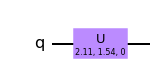

In [5]:
q = QuantumRegister(1,'q')
qc = QuantumCircuit(q)


theta = np.pi*np.random.random_sample()
phi = 2*np.pi*np.random.random_sample()
lamda = 0 # actually lambda is not necessary here, so I set it to zero

qc.u(theta, phi, lamda, q)  # U_3(...) gate

state_vector = execute(qc, state_simulator).result().get_statevector(qc, decimals=3)
r = bloch_vetor(state_vector)
print(f"\n|\u03C8> = {state_vector} \n\n|<\u03C8|\u03C8>| = {np.linalg.norm(state_vector)}\n")
# print(f"|\u03C8> = {qubit(theta,phi)}") # compute the state using qubit(...), just to check.

print(f"\nBloch_vector:\nr = {r} \n\n|r| = {np.linalg.norm(r)}")
print("\n\n\nCircuit:")
qc.draw(output='mpl')

### 2. Swap test 
In the following cells I generate a qiskit circuit to implement the *Swap test*. I generate the states $U_{3}(\theta_1, \phi_1, 0) | 0 \rangle  = | q_1 \rangle $ and $U_{3}(\theta_2, \phi_2, 0) | 0 \rangle  = | q_1 \rangle $ by choosing the parameters $\theta_1$, $\phi_1$, $\theta_2$ and $\phi_2$ (I set $\lambda = 0$ in both cases) at random.

In [6]:
NUM_SHOTS = 10000


def circuit_generator(params, args):
    
    q = QuantumRegister(3,'q')
    c = ClassicalRegister(1,'c')
    qc = QuantumCircuit( q, c )
    qc.h(0)
    qc.u(args[0], args[1], 0, q[1]) # target state
    qc.u(params[0], params[1], 0, q[2])  # test state 
    qc.cswap(q[0],q[1],q[2])
    qc.h(0)
    qc.measure(q[0],c[0])
    
    return qc


def objective_function(params, args):

    qc = circuit_generator(params, args)
    result = execute(qc, backend_experimet, shots=NUM_SHOTS).result()
    counts = result.get_counts()
    P = counts['0']/NUM_SHOTS

    return 1 - P # We want to minimize this function


Next, I show a circuit generated with `experiment(...)`

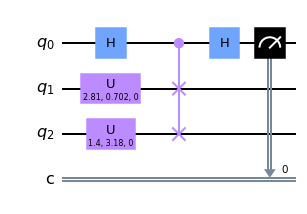

In [12]:
y0, y1 = parameters()  # parameters for |q1>
x0, x1 = parameters()  # parameters for |q2>
circuit = circuit_generator([x0, x1], [y0, y1])

circuit.draw(output='mpl')

**Finding the best choice of parameters**:

The best parameters are those that maximize the probability of measuring $| 0 \rangle$ in the circuit above. To find the parameters I implement the *COBYLA* optimizer to minimize `objective_function(...) `, this is $1 - P\left( | 0 \rangle \right)$. 

In [14]:
y0, y1 = parameters()   # This two parameters generate a random "target state" |q1>
x0, x1 = parameters()   # initial guess for the optimizer

initial_guess = np.array([x0,x1])

res = minimize(objective_function , initial_guess , args= ([y0,y1]),  method='COBYLA', tol = 1e-20, 
                options={'maxiter':6000})

Now, to check that the found coefficients reproduce the target state, I compute the fidelity between the target state and the state generated with the parameters found in the optimization. Here, I use `qubit(...)` to generate the states.

In [15]:
unknown_state = qubit(y0,y1)
found_state = qubit(res.x[0], res.x[1])
fidelity = quantum_info.state_fidelity(unknown_state,  found_state)

print(f"|q1> = {unknown_state}\n")
print(f"|q2> = {found_state}\n")
print(f"Fidelity = {fidelity}")

|q1> = [ 0.90499815+0.j         -0.39288735-0.16314988j]

|q2> = [ 0.9003126 +0.j         -0.40975091-0.14676995j]

Fidelity = 0.999509843052611


### 3. Swap test to reconstruct a random generated product state of qubits.

I first show an implementation to solve part 3) using qiskit. The random product state is formed by kronecker products of $|0\rangle$'s and $|1\rangle$'s. The *$N$-qubit state product* is computed from a string of bits, called *bit_string*, which is generated at random. A `0` in the *i-th* entry of *bit_string* corresponds to a $|0\rangle$ in the *i-th* qubit of the circuit (a `1` corresponds to a $|1\rangle$, achieved by applying the $X$ gate).

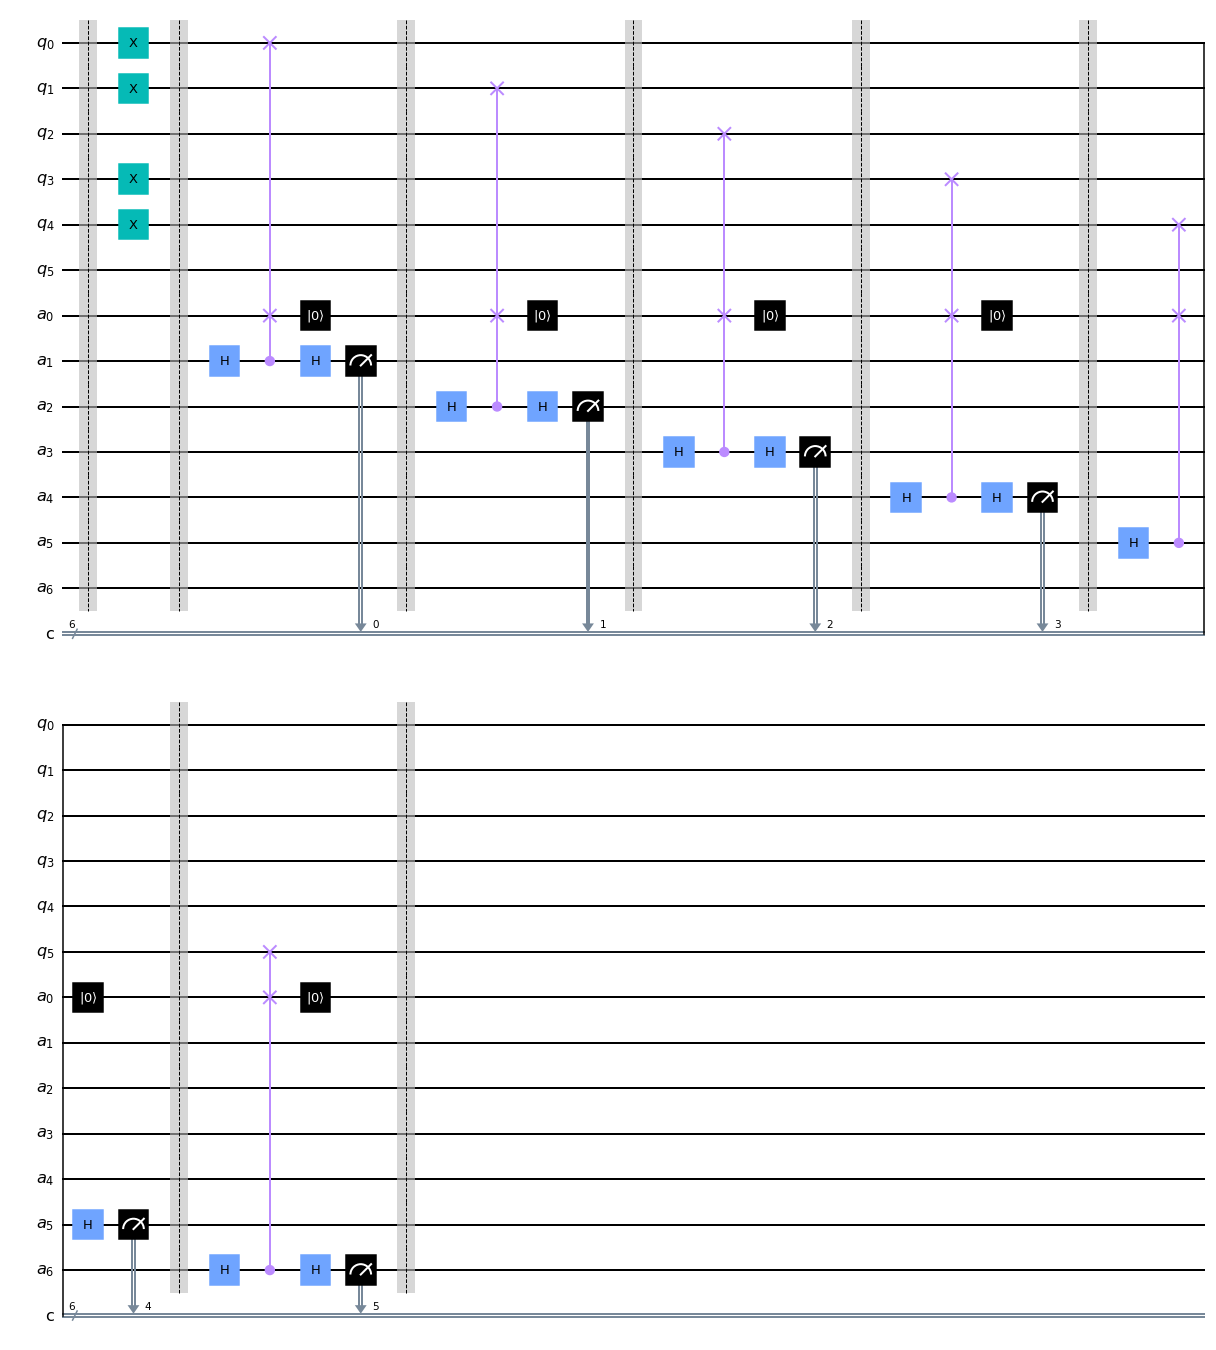

In [16]:
N = np.random.choice([i for i in range(2,7)])   # get a random number of qubits N

q = QuantumRegister(N ,'q')
a = QuantumRegister(N+1,'a')
c = ClassicalRegister(N ,'c')

qc = QuantumCircuit( q, a, c )

##################### random  product state #####################
qc.barrier()
bit_string = np.random.randint(2, size = N)
for i in range(N):
    if bit_string[i] == 1:
        qc.x(q[i])
qc.barrier()
#################################################################
    
for i in range(N):
    qc.h(N +  i + 1)
    qc.cswap(a[i+1],a[0],q[i])
    qc.h(N + i + 1)
    qc.reset(a[0])
    qc.measure(a[i + 1],c[i])
    qc.barrier()

qc.draw(output='mpl')

In [17]:
print(f"bit_string = {bit_string}")

bit_string = [1 1 0 1 1 0]


In [18]:
num_of_shots = 10000
job = execute(qc, backend_experimet, shots=num_of_shots)
counts = job.result().get_counts()

In [19]:
R = []
for i in list(counts.keys()):
    R.append(list(map(int,i)))
R = np.flip(R, axis=1)
idx_max = np.argmax( np.sum(R, axis=1) )
print(f"The unknown state is |{''.join(list(map(str,R[idx_max])))}>")
    

The unknown state is |110110>


Now, I implement `swap_test_Nq(...)`, to solve the same problem

In [20]:
product_state = qubit_string(bit_string)
print(f"\nTarget state = |{''.join(map(str,list(bit_string)))}>\n")

resulting_state = swap_test_Nq(N, product_state)
print(f"Found state = |{resulting_state}>")


Target state = |110110>

Found state = |110110>
